In [544]:
import pandas as pd
import matplotlib.pyplot as plt

In [545]:
########## Balance mix strategy

In [624]:
busiest_day= pd.read_csv(r'../../results/busiest-day-trips-info.csv', low_memory=False)

In [626]:
busiest_day

,TripKey,Date,Route,Stop_first,Stop_last,ServiceDateTime_min,ServiceDateTime_max,Energy,dist,Powertrain,Diesel
0,504451,2021-10-29,(X) 902,850,1920,2021-10-29 11:22:06,2021-10-29 11:28:50,1.676845,3.527633,electric,0.0
1,504614,2021-10-29,(X) 902,5105,850,2021-10-29 15:06:30,2021-10-29 15:31:15,9.951124,6.489336,electric,0.0
2,504672,2021-10-29,(X) 902,5105,850,2021-10-29 12:37:10,2021-10-29 13:00:22,11.354240,6.489336,electric,0.0
3,504850,2021-10-29,(X) 902,5105,5105,2021-10-29 17:36:16,2021-10-29 17:36:16,-0.001517,0.079722,electric,-0.0
4,504944,2021-10-29,(X) 902,850,1920,2021-10-29 13:50:58,2021-10-29 13:57:06,2.015950,3.527633,electric,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2361,505502,2021-10-29,X92,850,5114,2021-10-29 13:00:19,2021-10-29 14:00:19,4.620228,4.907396,electric,0.0
2362,507042,2021-10-29,X92,5114,850,2021-10-29 12:01:34,2021-10-29 13:00:19,8.419038,5.847957,electric,0.0
2363,507043,2021-10-29,X92,5114,850,2021-10-29 14:00:19,2021-10-29 15:00:01,9.712780,5.690529,electric,0.0
2364,507044,2021-10-29,X92,850,5114,2021-10-29 16:48:52,2021-10-29 18:02:00,2.352436,4.907396,electric,0.0


In [628]:
# Assuming busiest_day is your dataframe
busiest_day['Route'] = busiest_day['Route'].str.replace(r'\(X\)', '', regex=True) # replace (X)
busiest_day['Route'] = busiest_day['Route'].str.replace('X', '', regex=False) # replace X

busiest_day

,TripKey,Date,Route,Stop_first,Stop_last,ServiceDateTime_min,ServiceDateTime_max,Energy,dist,Powertrain,Diesel
0,504451,2021-10-29,902,850,1920,2021-10-29 11:22:06,2021-10-29 11:28:50,1.676845,3.527633,electric,0.0
1,504614,2021-10-29,902,5105,850,2021-10-29 15:06:30,2021-10-29 15:31:15,9.951124,6.489336,electric,0.0
2,504672,2021-10-29,902,5105,850,2021-10-29 12:37:10,2021-10-29 13:00:22,11.354240,6.489336,electric,0.0
3,504850,2021-10-29,902,5105,5105,2021-10-29 17:36:16,2021-10-29 17:36:16,-0.001517,0.079722,electric,-0.0
4,504944,2021-10-29,902,850,1920,2021-10-29 13:50:58,2021-10-29 13:57:06,2.015950,3.527633,electric,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2361,505502,2021-10-29,92,850,5114,2021-10-29 13:00:19,2021-10-29 14:00:19,4.620228,4.907396,electric,0.0
2362,507042,2021-10-29,92,5114,850,2021-10-29 12:01:34,2021-10-29 13:00:19,8.419038,5.847957,electric,0.0
2363,507043,2021-10-29,92,5114,850,2021-10-29 14:00:19,2021-10-29 15:00:01,9.712780,5.690529,electric,0.0
2364,507044,2021-10-29,92,850,5114,2021-10-29 16:48:52,2021-10-29 18:02:00,2.352436,4.907396,electric,0.0


In [629]:
### BM High-cap Scenario

In [630]:
h_BM_variables = pd.read_csv(r'../../results/highcap-BM-optimized-variables.csv', low_memory=False)

In [631]:
h_BM_coefficients = pd.read_csv(r'../../results/optimization-coefficients.csv', low_memory=False)

In [632]:
# Extract attributes from h_BM_variables
h_BM_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = h_BM_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')
h_BM_variables = h_BM_variables.dropna()
h_BM_variables['Year'] = h_BM_variables['Year'].astype(int).copy()
# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
h_BM_variables['Trip'] = h_BM_variables['Trip'].astype(str)
busiest_day['TripKey'] = busiest_day['TripKey'].astype(str)


# Extract attributes from h_BM_coefficients
h_BM_coefficients[['Scenario', 'Year', 'Trip']] = h_BM_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")
h_BM_coefficients = h_BM_coefficients.dropna()
h_BM_coefficients['Year'] = h_BM_coefficients['Year'].astype(int)

# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
h_BM_variables['Trip'] = h_BM_variables['Trip'].astype(str)
h_BM_coefficients['Trip'] = h_BM_coefficients['Trip'].astype(str)

# Merge the dataframes on matching values
merged_df = h_BM_variables.merge(h_BM_coefficients[['Powertrain','Year', 'Trip', 'Coefficient']],
                                on=['Powertrain','Year', 'Trip',],
                                how='left')

# Update h_BM_variables
h_BM_variables = merged_df

In [633]:
# Merge the dataframes on matching values
merged_df = h_BM_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update h_BM_variables
h_BM_variables = merged_df

h_BM_variables['ServiceDateTime_min'] = pd.to_datetime(h_BM_variables['ServiceDateTime_min'])
h_BM_variables['ServiceDateTime_max'] = pd.to_datetime(h_BM_variables['ServiceDateTime_max'])
#h_BM_variables['Value'] = pd.to_numeric(h_BM_variables['Value'])

In [634]:
h_BM_variables.to_csv(r'../../results/highcap-BM-optimized-variables-aggregated.csv', index=False)

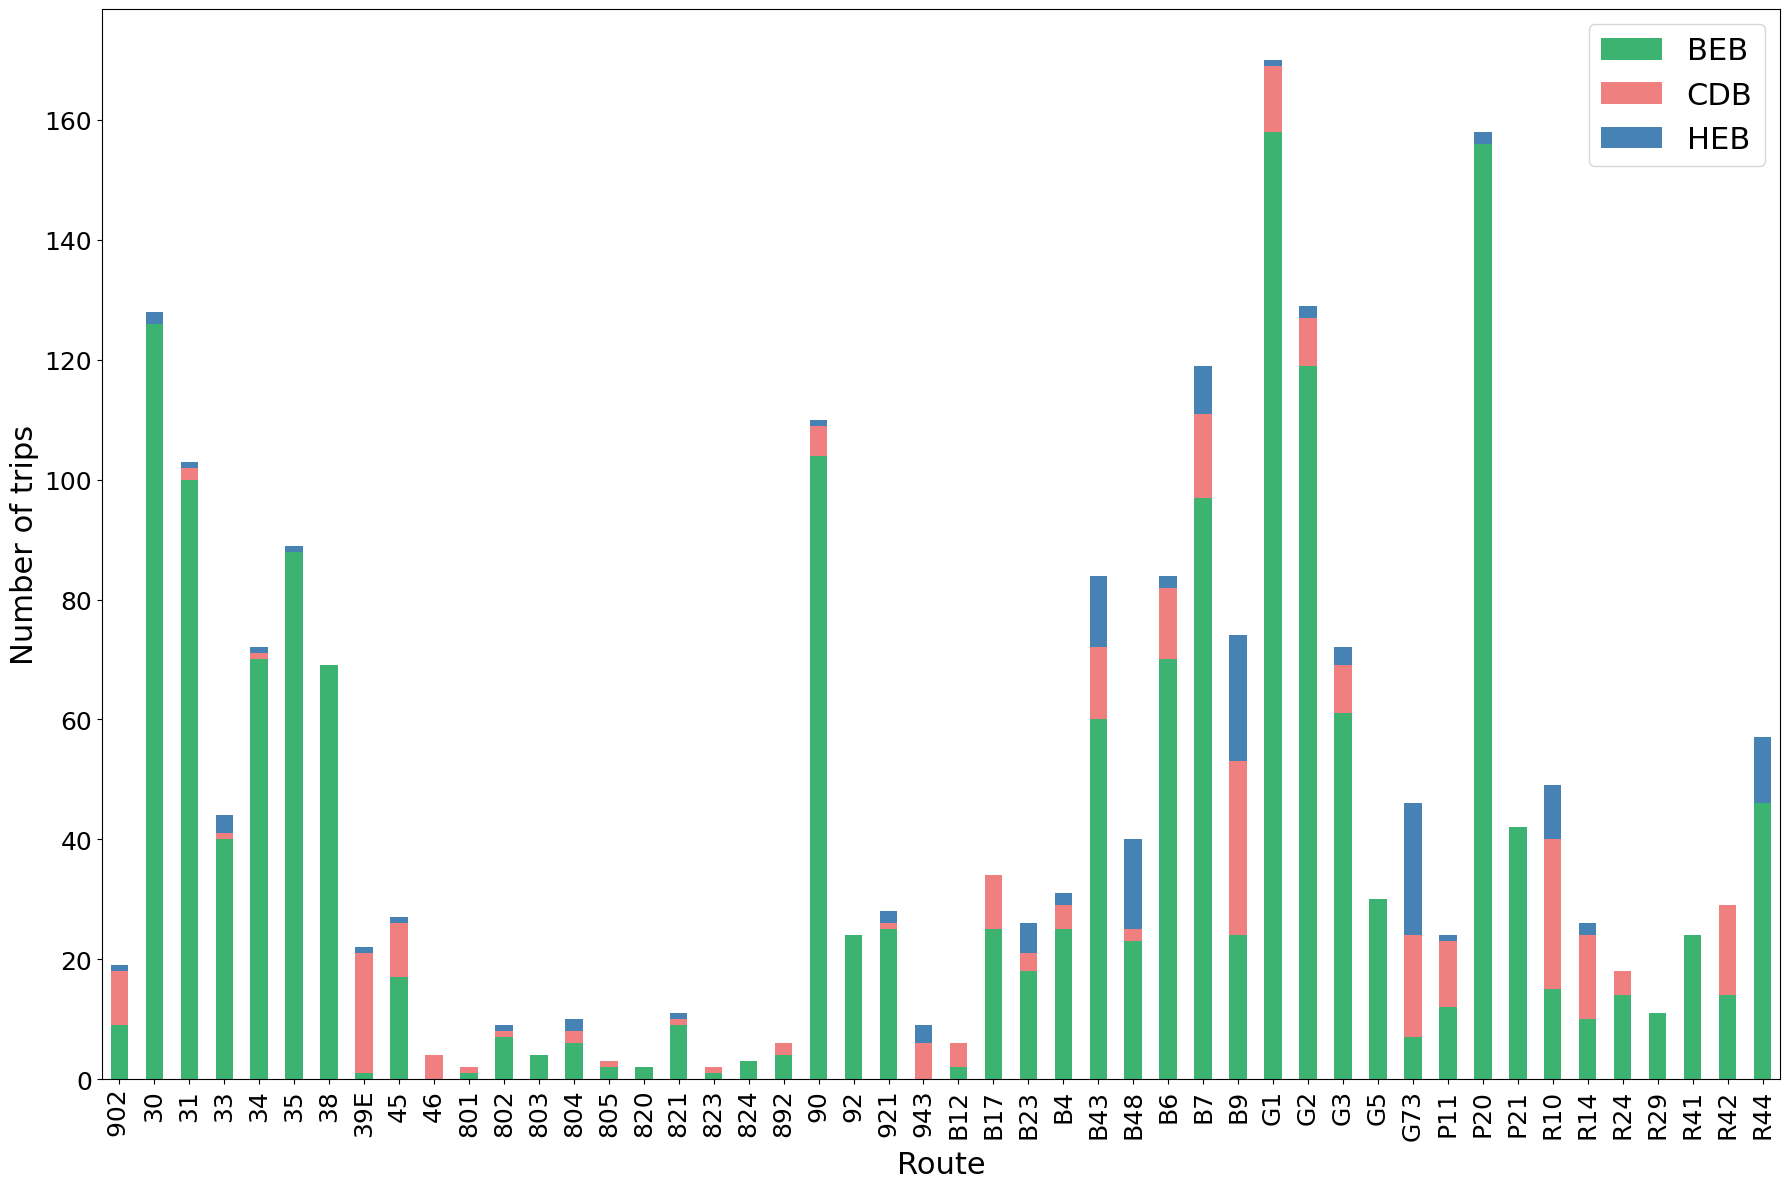

In [635]:
# Filter the dataframe for Year=13 and Value=1
h_BM_variables_filtered = h_BM_variables[(h_BM_variables['Year'] == 12) & (h_BM_variables['Value'] == 1)]
h_BM_variables_filtered = h_BM_variables_filtered[h_BM_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = h_BM_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(18, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=22)
ax.set_ylabel('Number of trips', fontsize=22)
ax.legend(fontsize=22)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()

fig.savefig(r'../../figures/h_BM_route_electrification.png', dpi=400)  

plt.show()


In [636]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 81.31%


In [637]:
h_BM_variables_y = pd.read_csv(r'../../results/highcap-BM-optimized-variables-y.csv', low_memory=False)

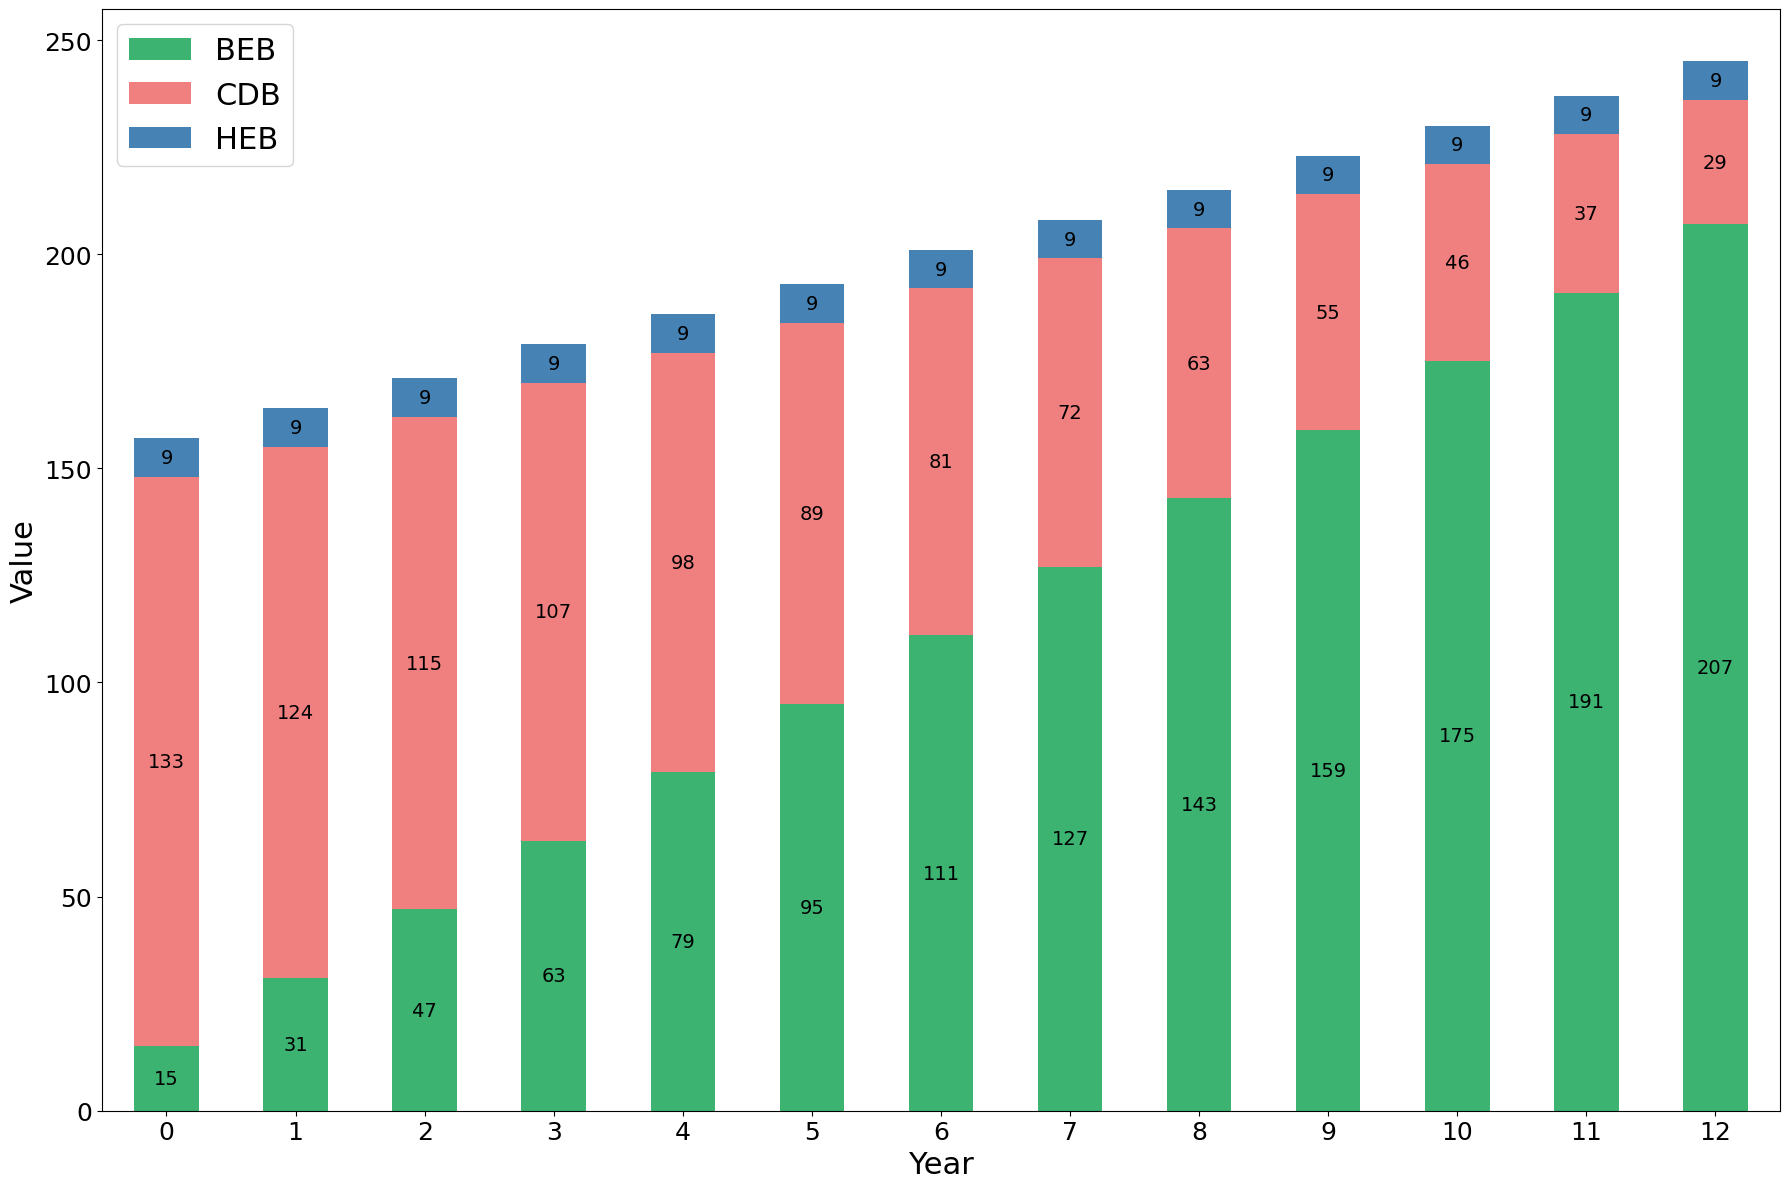

In [638]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = h_BM_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(18, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate bars with the segment values
for container in ax.containers:
    for rect in container:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',  # Dropped the decimals by converting to int
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                    ha='center', 
                    va='center',
                    color='black',  
                    fontsize=14)

# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=22)
ax.set_ylabel('Value', fontsize=22)
ax.legend(fontsize=22)
ax.set_xticklabels(grouped_values.index, rotation=0)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()
fig.savefig(r'../../figures/h_BM_fleet.png', dpi=400)  

plt.show()


In [639]:
total_sum = (h_BM_variables['Value'] * h_BM_variables['Coefficient']).sum()
print(total_sum)

20162.814309215


In [640]:
### BM Mid-cap Scenario

In [641]:
busiest_day= pd.read_csv(r'../../results/busiest-day-trips-info.csv', low_memory=False)

In [642]:
m_BM_variables = pd.read_csv(r'../../results/midcap-BM-optimized-variables.csv', low_memory=False)

In [643]:
m_BM_coefficients = pd.read_csv(r'../../results/optimization-coefficients.csv', low_memory=False)

In [644]:
# Extract attributes from m_BM_variables
m_BM_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = m_BM_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')
m_BM_variables = m_BM_variables.dropna()
m_BM_variables['Year'] = m_BM_variables['Year'].astype(int).copy()
# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
m_BM_variables['Trip'] = m_BM_variables['Trip'].astype(str)
busiest_day['TripKey'] = busiest_day['TripKey'].astype(str)


# Extract attributes from m_BM_coefficients
m_BM_coefficients[['Scenario', 'Year', 'Trip']] = m_BM_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")
m_BM_coefficients = m_BM_coefficients.dropna()
m_BM_coefficients['Year'] = m_BM_coefficients['Year'].astype(int)

# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
m_BM_variables['Trip'] = m_BM_variables['Trip'].astype(str)
m_BM_coefficients['Trip'] = m_BM_coefficients['Trip'].astype(str)

# Merge the dataframes on matching values
merged_df = m_BM_variables.merge(m_BM_coefficients[['Powertrain','Year', 'Trip', 'Coefficient']],
                                on=['Powertrain','Year', 'Trip',],
                                how='left')

# Update m_BM_variables
m_BM_variables = merged_df

In [645]:
# Merge the dataframes on matching values
merged_df = m_BM_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update h_BM_variables
m_BM_variables = merged_df

m_BM_variables['ServiceDateTime_min'] = pd.to_datetime(m_BM_variables['ServiceDateTime_min'])
m_BM_variables['ServiceDateTime_max'] = pd.to_datetime(m_BM_variables['ServiceDateTime_max'])
#h_BM_variables['Value'] = pd.to_numeric(h_BM_variables['Value'])

In [646]:
m_BM_coefficients

,Powertrain,Variable,Coefficient,Scenario,Year,Trip
0,CDB,"('high-cap', 0, 504451)",0.247132,high-cap,0,504451
1,CDB,"('high-cap', 1, 504451)",0.247132,high-cap,1,504451
2,CDB,"('high-cap', 2, 504451)",0.247132,high-cap,2,504451
3,CDB,"('high-cap', 3, 504451)",0.247132,high-cap,3,504451
4,CDB,"('high-cap', 4, 504451)",0.247132,high-cap,4,504451
...,...,...,...,...,...,...
99367,BEB,"('high-cap', 9, 507069)",0.000000,high-cap,9,507069
99368,BEB,"('high-cap', 10, 507069)",0.000000,high-cap,10,507069
99369,BEB,"('high-cap', 11, 507069)",0.000000,high-cap,11,507069
99370,BEB,"('high-cap', 12, 507069)",0.000000,high-cap,12,507069


In [647]:
m_BM_variables.to_csv(r'../../results/midcap-BM-optimized-variables-aggregated.csv', index=False)

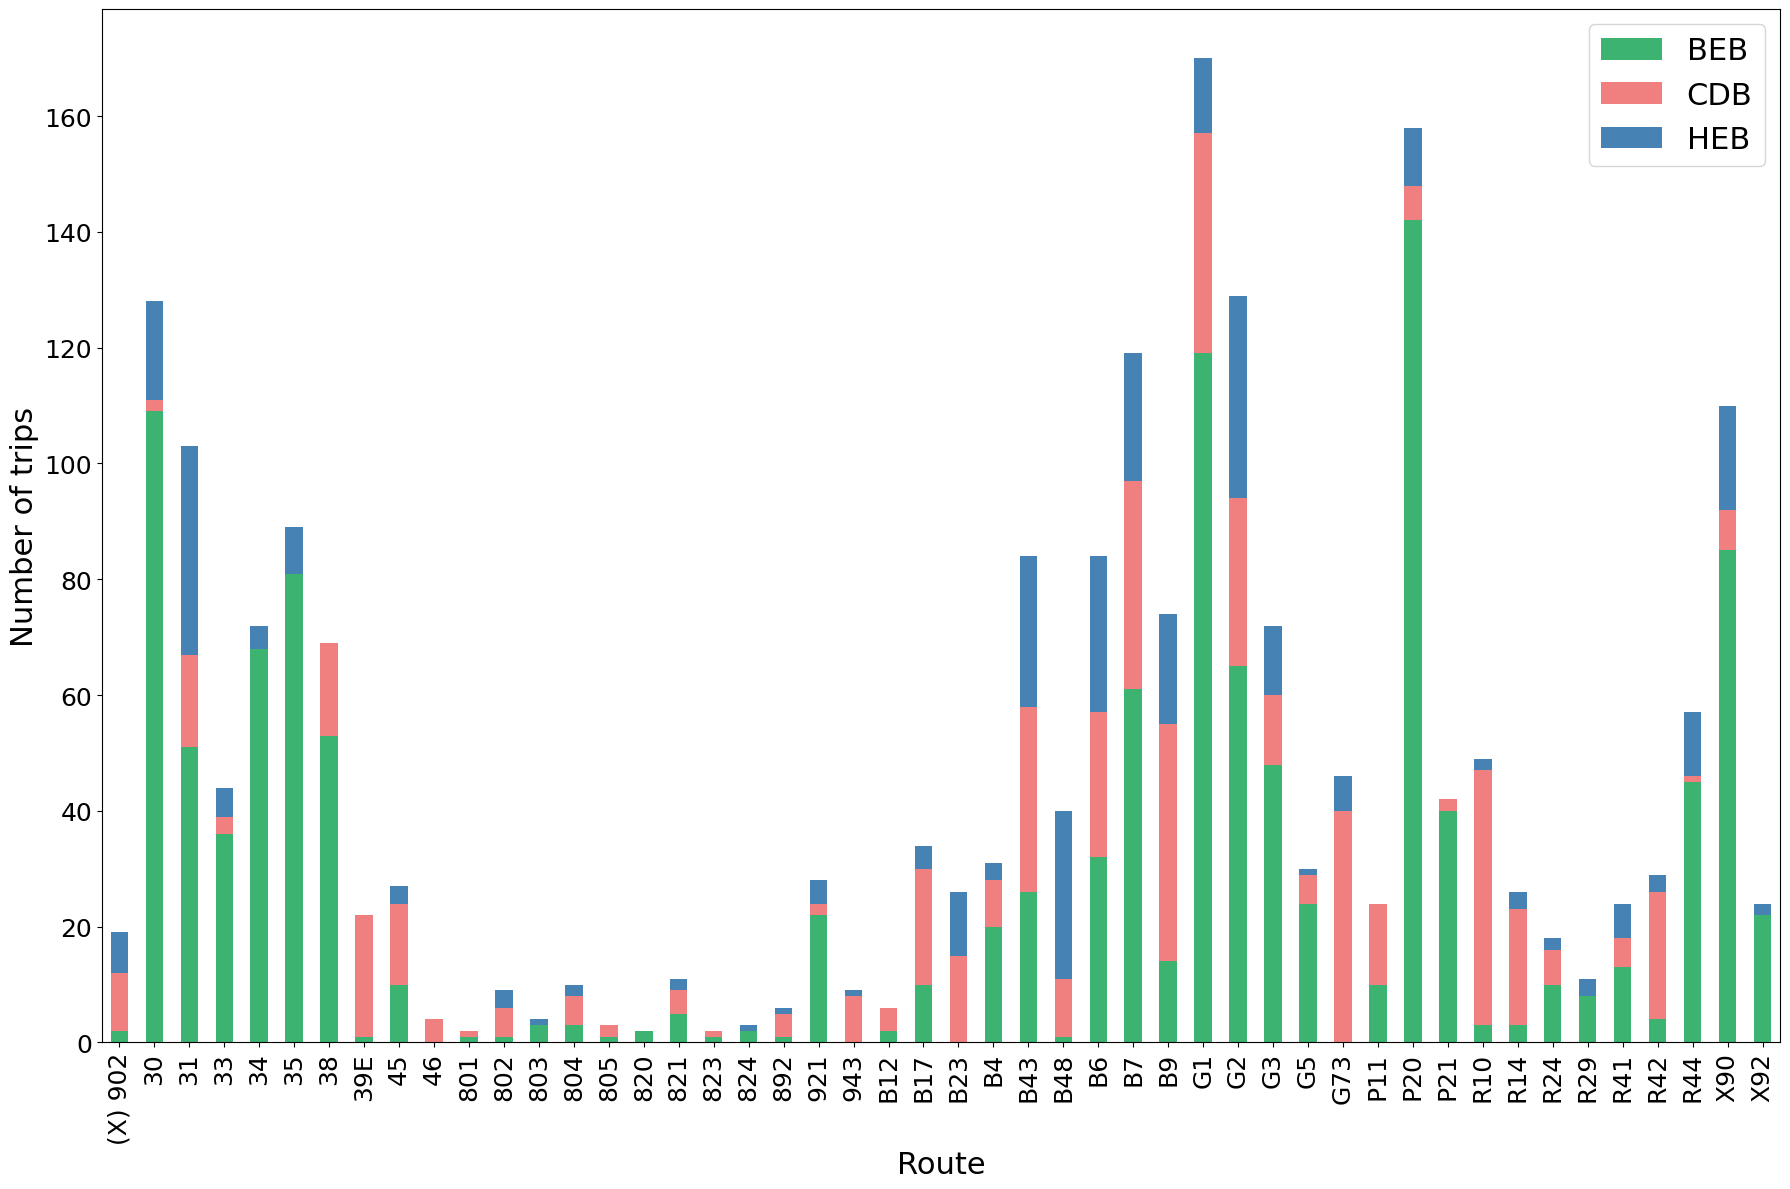

In [648]:
# Filter the dataframe for Year=13 and Value=1
m_BM_variables_filtered = m_BM_variables[(m_BM_variables['Year'] == 12) & (m_BM_variables['Value'] == 1)]
m_BM_variables_filtered = m_BM_variables_filtered[m_BM_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = m_BM_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(18, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=22)
ax.set_ylabel('Number of trips', fontsize=22)
ax.legend(fontsize=22)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()
fig.savefig(r'../../figures/m_BM_route_electrification.png', dpi=400)  

plt.show()


In [649]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 57.72%


In [650]:
m_BM_variables_y = pd.read_csv(r'../../results/midcap-BM-optimized-variables-y.csv', low_memory=False)

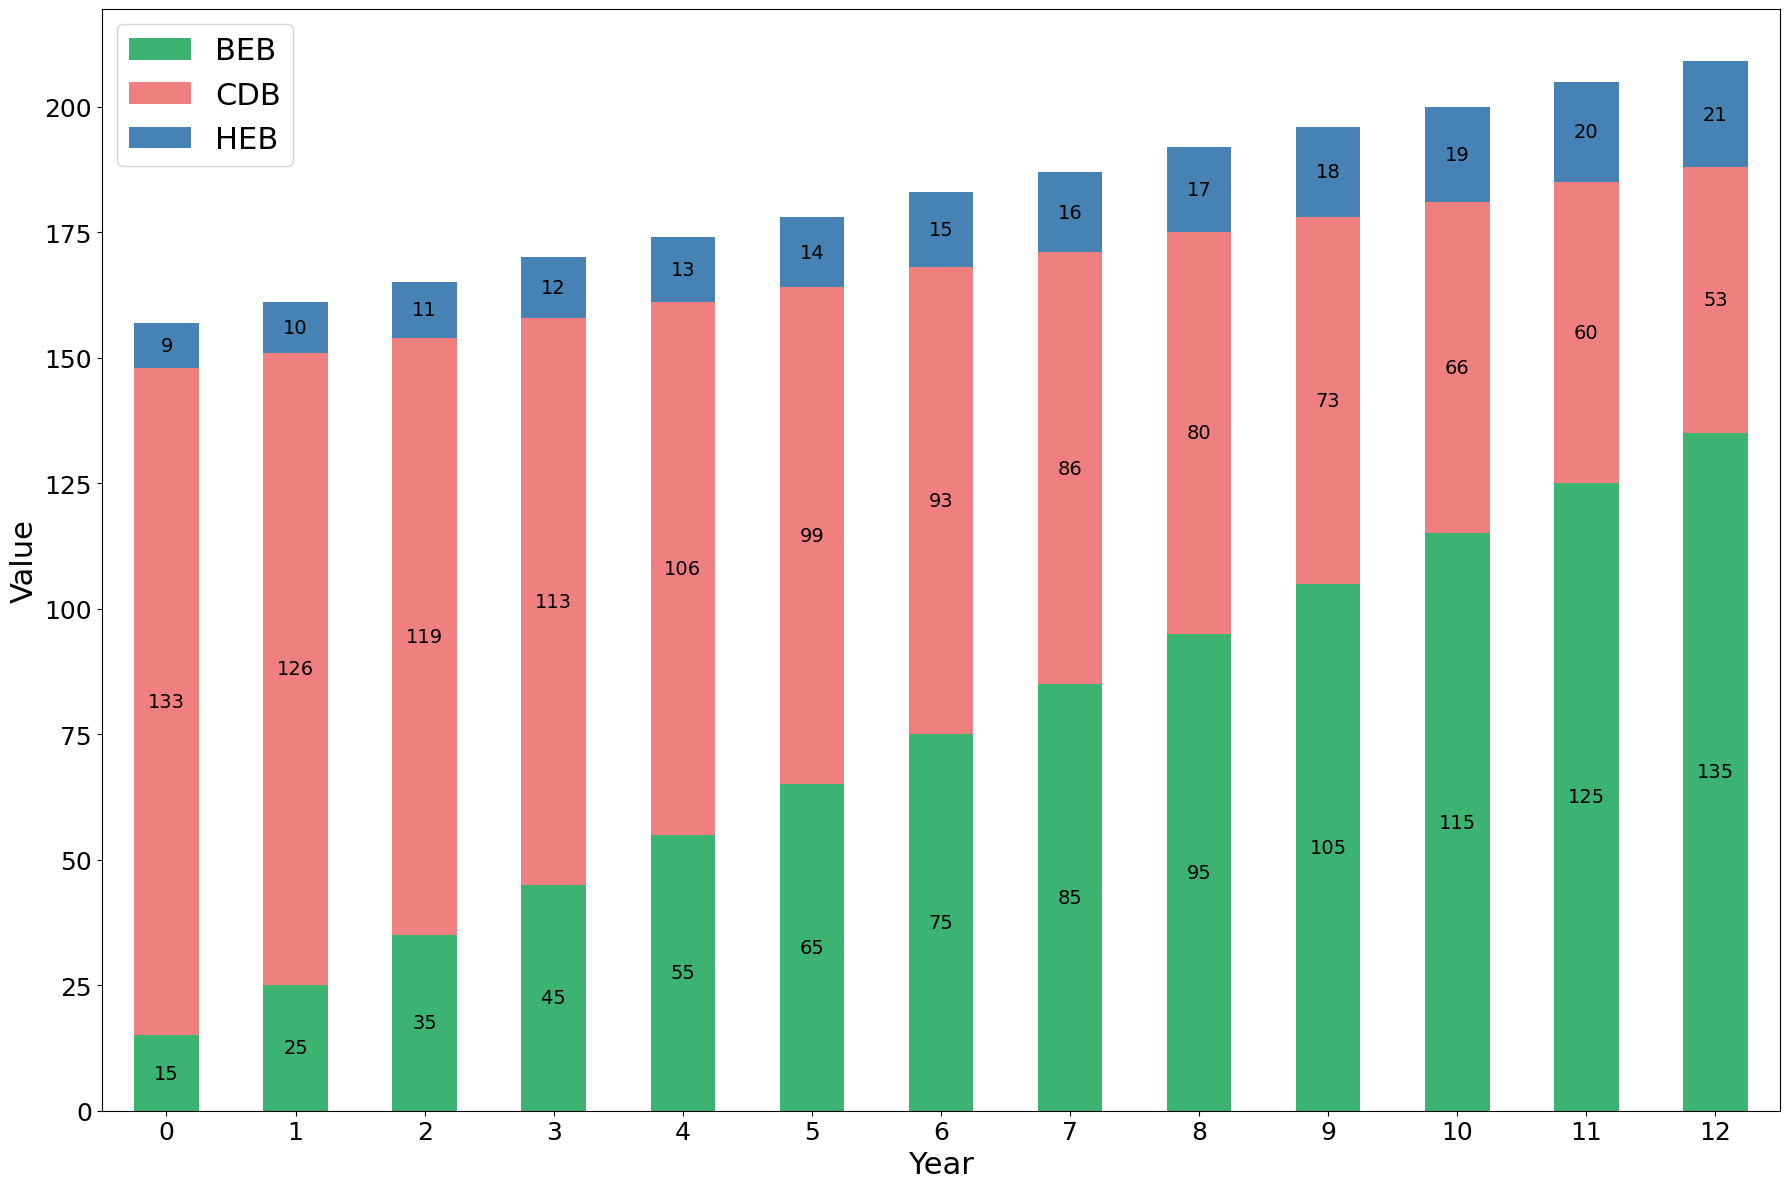

In [651]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = m_BM_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(18, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate bars with the segment values
for container in ax.containers:
    for rect in container:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',  # Dropped the decimals by converting to int
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                    ha='center', 
                    va='center',
                    color='black',  
                    fontsize=14)    

# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=22)
ax.set_ylabel('Value', fontsize=22)
ax.legend(fontsize=22)
ax.set_xticklabels(grouped_values.index, rotation=0)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=18)
fig.savefig(r'../../figures/m_BM_fleet.png', dpi=400)  

plt.tight_layout()
plt.show()

In [652]:
total_sum = (m_BM_variables['Value'] * m_BM_variables['Coefficient']).sum()
print(total_sum)

25039.071440149


In [653]:
### BM Low-cap Scenario

In [654]:
l_BM_variables = pd.read_csv(r'../../results/lowcap-BM-optimized-variables.csv', low_memory=False)

In [655]:
l_BM_coefficients = pd.read_csv(r'../../results/optimization-coefficients.csv', low_memory=False)

In [656]:
# Extract attributes from l_BM_variables
l_BM_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = l_BM_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')
l_BM_variables = l_BM_variables.dropna()
l_BM_variables['Year'] = l_BM_variables['Year'].astype(int)
# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
l_BM_variables['Trip'] = l_BM_variables['Trip'].astype(str)

# Extract attributes from h_BM_coefficients
l_BM_coefficients[['Scenario', 'Year', 'Trip']] = l_BM_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")
l_BM_coefficients = l_BM_coefficients.dropna()
l_BM_coefficients['Year'] = l_BM_coefficients['Year'].astype(int)

# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
l_BM_variables['Trip'] = l_BM_variables['Trip'].astype(str)
l_BM_coefficients['Trip'] = l_BM_coefficients['Trip'].astype(str)

# Merge the dataframes on matching values
merged_df = l_BM_variables.merge(l_BM_coefficients[['Powertrain','Year', 'Trip', 'Coefficient']],
                                on=['Powertrain','Year', 'Trip',],
                                how='left')

# Update l_BM_variables
l_BM_variables = merged_df

In [657]:
# Merge the dataframes on matching values
merged_df = l_BM_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update l_BM_variables
l_BM_variables = merged_df

l_BM_variables['ServiceDateTime_min'] = pd.to_datetime(l_BM_variables['ServiceDateTime_min'])
l_BM_variables['ServiceDateTime_max'] = pd.to_datetime(l_BM_variables['ServiceDateTime_max'])

In [658]:
l_BM_variables.to_csv(r'../../results/lowcap-BM-optimized-variables-aggregated.csv', index=False)

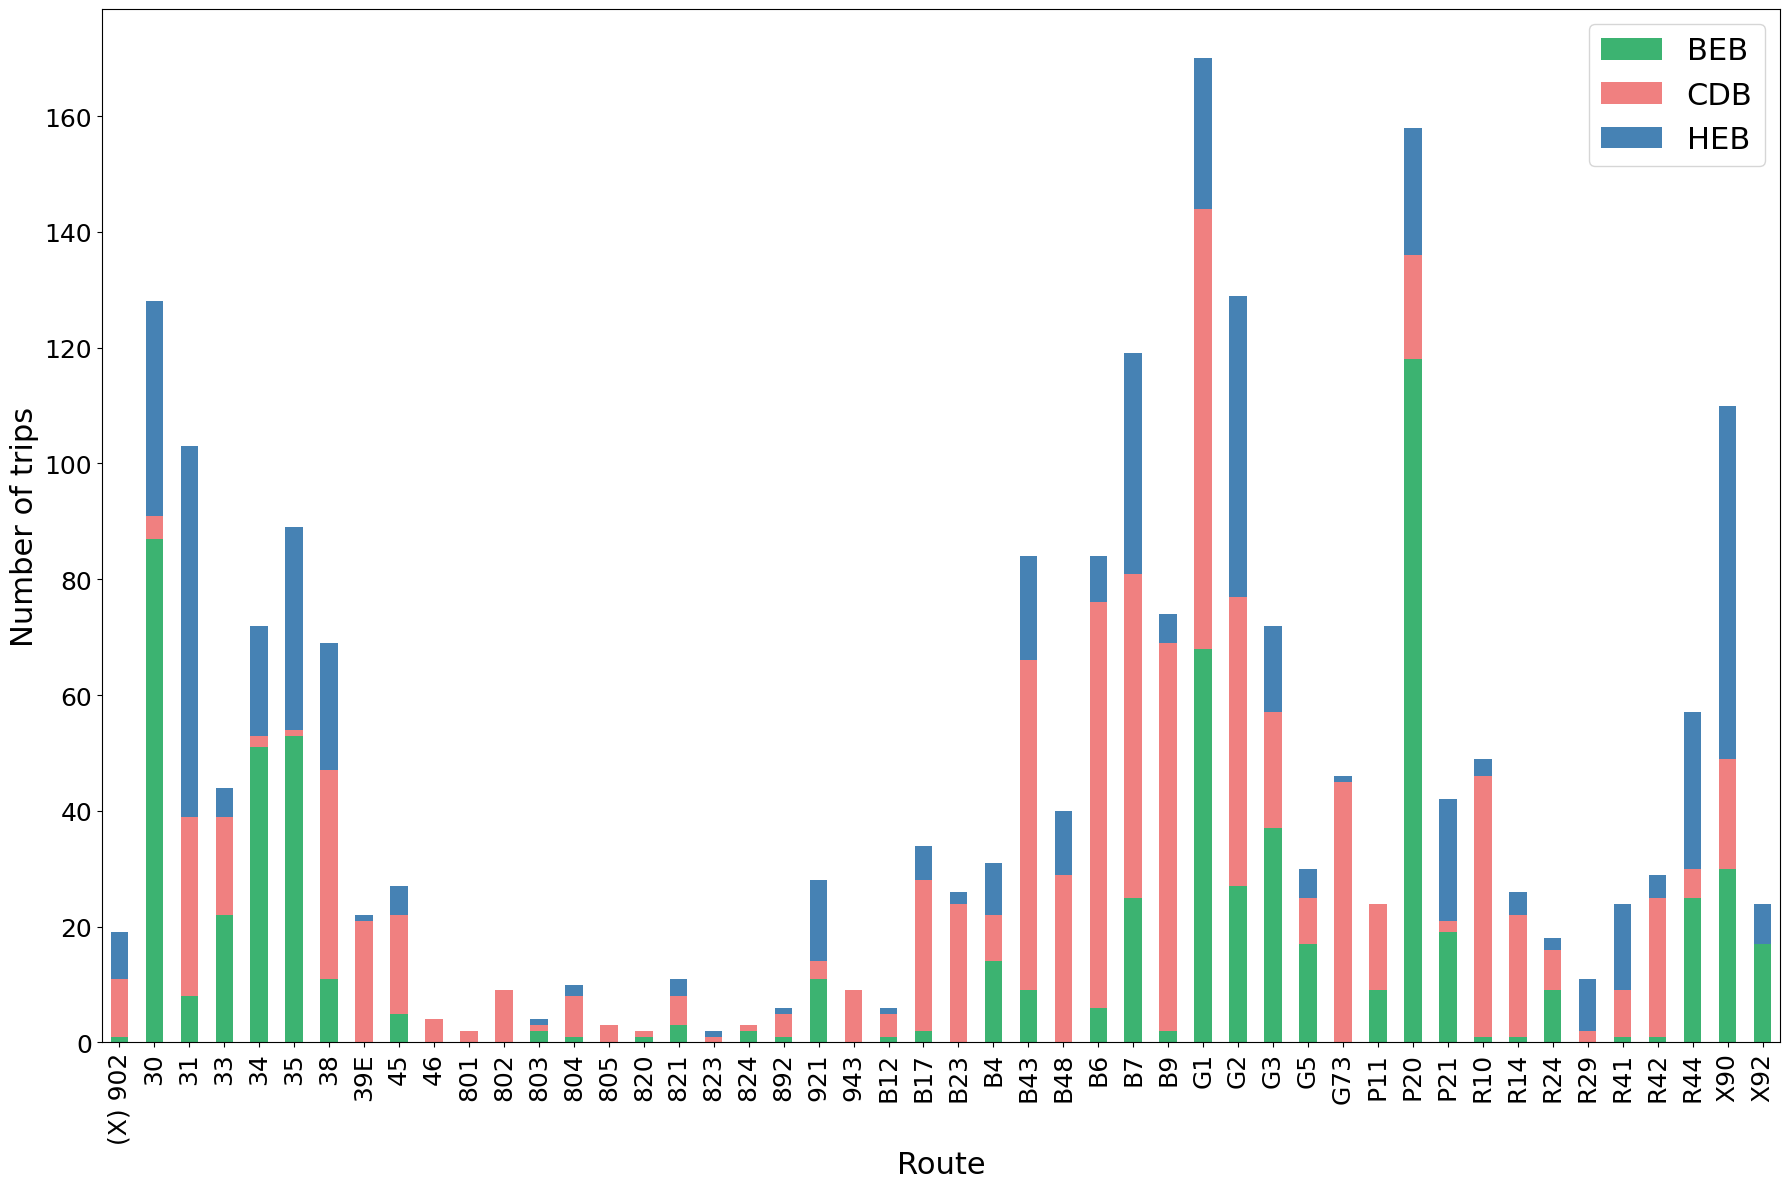

In [659]:
# Filter the dataframe for Year=13 and Value=1
l_BM_variables_filtered = l_BM_variables[(l_BM_variables['Year'] == 12) & (l_BM_variables['Value'] == 1)]
l_BM_variables_filtered = l_BM_variables_filtered[l_BM_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = l_BM_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(18, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=22)
ax.set_ylabel('Number of trips', fontsize=22)
ax.legend(fontsize=22)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()
fig.savefig(r'../../figures/l_BM_route_electrification.png', dpi=400)  

plt.show()


In [660]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 31.97%


In [661]:
l_BM_variables_y = pd.read_csv(r'../../results/lowcap-BM-optimized-variables-y.csv', low_memory=False)

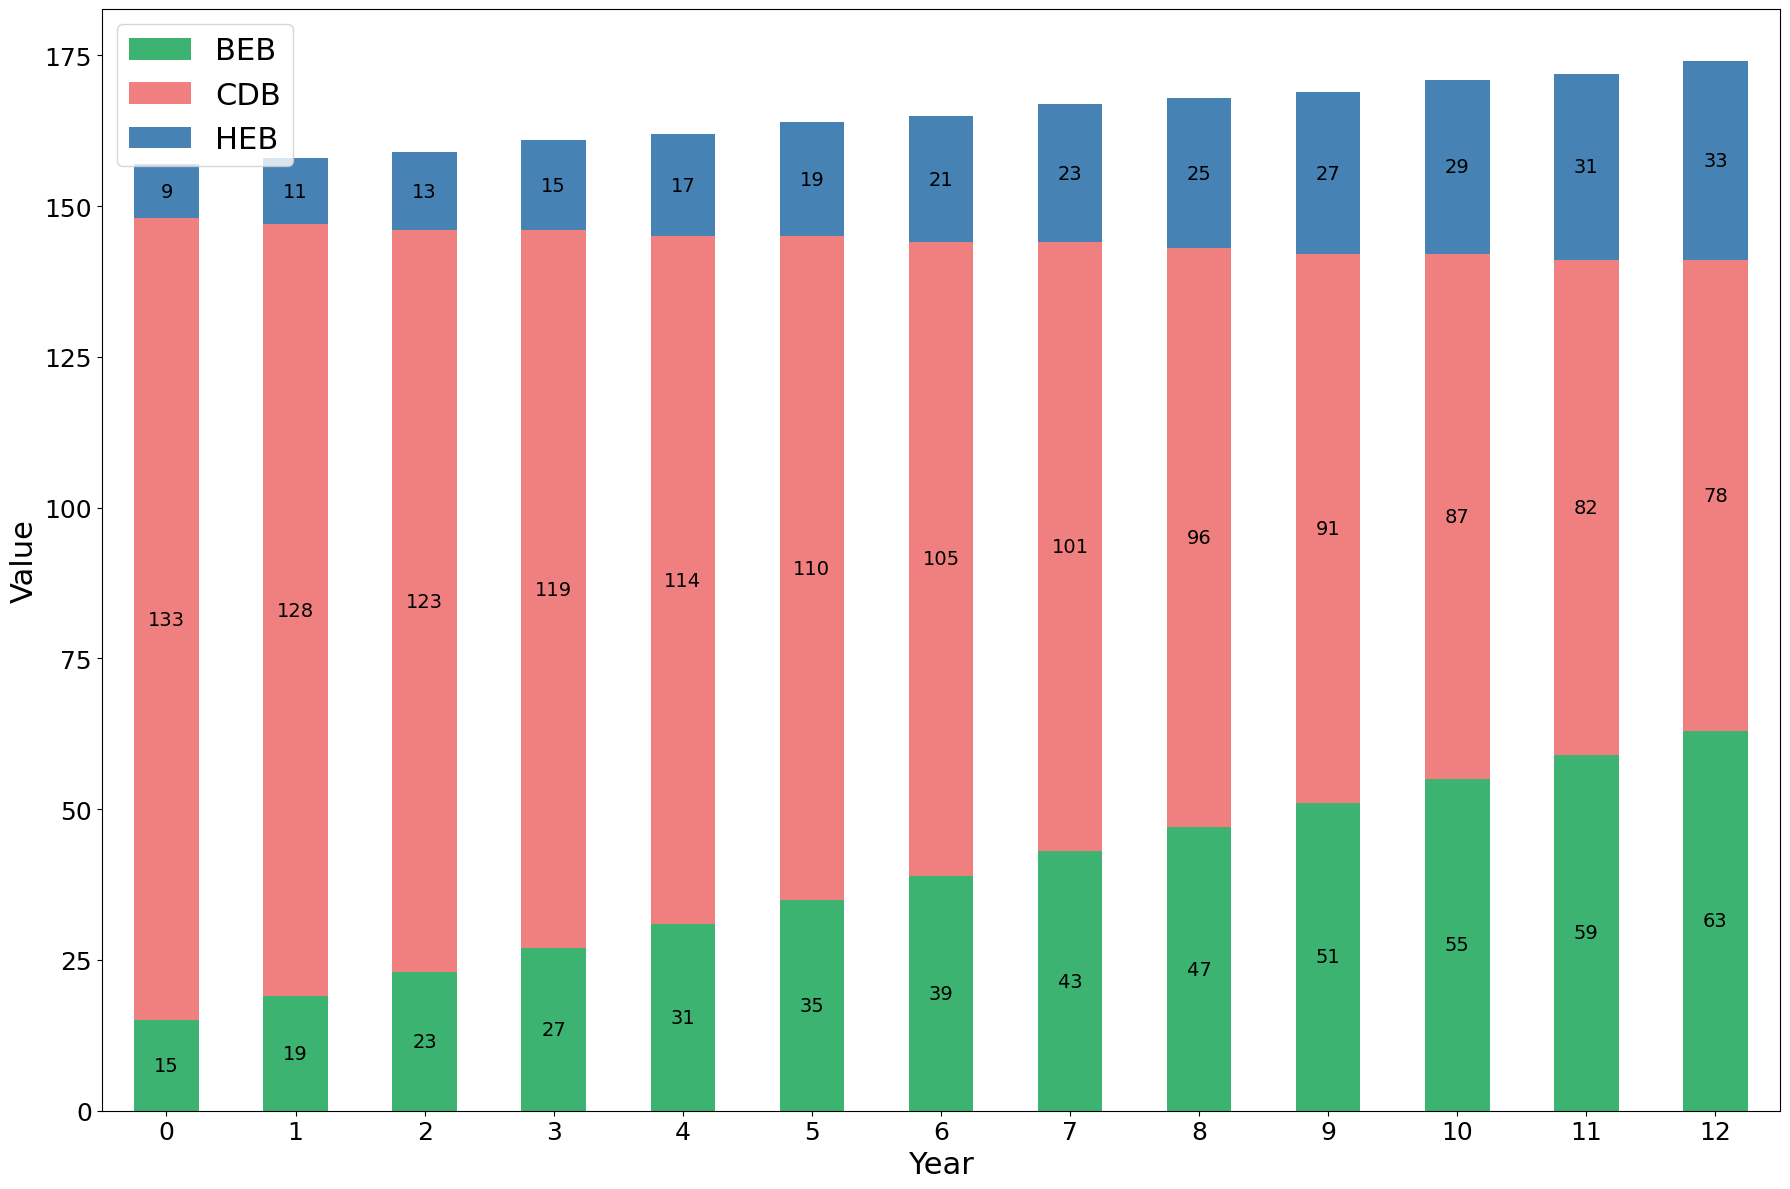

In [662]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = l_BM_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Plot
fig, ax = plt.subplots(figsize=(18, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate bars with the segment values
for container in ax.containers:
    for rect in container:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',  # Dropped the decimals by converting to int
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                    ha='center', 
                    va='center',
                    color='black',  
                    fontsize=14)

# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=22)
ax.set_ylabel('Value', fontsize=22)
ax.legend(loc='upper left', fontsize=22)
ax.set_xticklabels(grouped_values.index, rotation=0)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=18)

plt.tight_layout()

# Save the figure
fig.savefig(r'../../figures/l_BM_fleet.png', dpi=400)  

plt.show()


In [663]:
total_sum = (l_BM_variables['Value'] * l_BM_variables['Coefficient']).sum()
print(total_sum)

30487.218356921003
